In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from qa_summer.QSVR import QSVR
from dimod import ExactSolver
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from utils import nb_utils

In [2]:
df_info = nb_utils.get_df_info('mlpf')
df = pd.read_csv(df_info['df_path'])
df = df.drop(df[df.loss_99 == df.loss_99.max()].index)
df.head()
save = False

In [3]:
# train dataset
random_seed = 10 

curve = nb_utils.get_curve(df_info=df_info, known_curve=0.25, df=df)
X = curve[:,[i for i in range(0,curve.shape[1],2)]]
y = nb_utils.get_target(df_info,df)

In [4]:
x_scaler = QuantileTransformer(n_quantiles=50,random_state=0)
X = x_scaler.fit_transform(X)
y_scaler =  QuantileTransformer(n_quantiles=50,random_state=0)
y = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train = X_train[:79,:]
y_train = y_train[:79]
X_train.shape, y_train.shape

((79, 13), (79,))

In [6]:
qsvr_model = QSVR.QSVR()

In [7]:
# calculate sklearn default values for C and gamma
n_features = X_train.shape[1]
gamma = 1/(n_features*X_train.var())
C = 1.0
print("Gamma = " + str(gamma))
print("C = " + str(C))

Gamma = 1.070349905089307
C = 1.0


In [43]:

#try to optimize regressor hps
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
best, C_best, epsilon_best, gamma_best = -100, None, None, None
for _ in range(1000):
	C = np.exp(np.random.uniform(np.log(1e-3),np.log(10.0)))
	gamma = np.exp(np.random.uniform(np.log(1e-3),np.log(10.0)))
	epsilon = np.exp(np.random.uniform(np.log(1e-3),np.log(1)))
	model = SVR(C=C,epsilon=epsilon,gamma=gamma)
	cvs, __ = nb_utils.small_train_r2_cv(model, X=X_train, y=y_train, train_size= 20, reps=5, test_size=0.74,rs=_)
	cvs = cvs.mean()
	if best < cvs:
		best = cvs
		C_best, epsilon_best, gamma_best = C, epsilon, gamma
print(f'Best cross validation average r^2 achieved on classical SVR is {best}')
print(f'-> Achieved using C={C_best}, epsilon={epsilon_best}, gamma={gamma_best}')

Best cross validation average r^2 achieved on classical SVR is 0.8875172083187295
-> Achieved using C=8.836178204816694, epsilon=0.02071095136869859, gamma=0.1865953227493358


In [55]:
# not working if I try to set gamma and C manually
# if the training set (n_samples) is not small enough it will fail to find and embedding. n_samples 28 is worse than 20 
# if K is incremented it also fails
#qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.1, k0 = 0.05, n_samples = 21, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=20, C = C, gamma = gamma) #insert stuff
'''
# best r2 up to now
qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=40)
'''
qsvr_model.fit(X_train, y_train, K = 3, B = 2, epsilon = 0.02, k0 = 0.05, n_samples = 20, num_reads = 2500, random_seed=random_seed, n_samples_for_gamma_and_C_optimizations=40)

best value for gamma is 0.1, best value for C is 67.61554302473918
Creating the QUBO Q matrix of size (120, 120)
Extracting nodes and couplers from Q
The problem has 120 nodes and 7140 couplers
Running with 120 nodes and 7140 couplers


In [56]:
from sklearn.metrics import mean_squared_error
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
mse = []
for i in range(y_pred.shape[0]):
    mse.append(mean_squared_error(y_pred[i],y_test))
mse

[0.03429610680617751,
 0.023691547073157817,
 0.03480001032455971,
 0.030065214698117647,
 0.02433444626593975,
 0.05412447760868702]

In [57]:
from sklearn.metrics import r2_score
# predict returns a 2d array with 6 different predictions for each x_i
y_pred = qsvr_model.predict(X_test)
r2 = []
for i in range(y_pred.shape[0]):
    r2.append(r2_score(y_pred[i],y_test))
r2

[0.7719437865163394,
 0.8513952587579899,
 0.769558367779164,
 0.7999838317066827,
 0.848953614763015,
 0.6957067587244434]

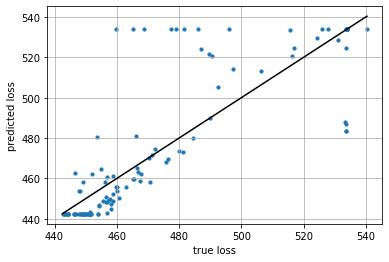

In [58]:
x = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y = y_scaler.inverse_transform(y_pred[0,:].reshape(-1, 1))
plt.scatter(x,y,s=10)
plt.plot([x.min(),x.max()],[x.min(),x.max()],'k')
plt.xlabel("true loss")
plt.ylabel("predicted loss")
plt.grid()
plt.show()

In [54]:
qsvr_attrs = {
	'X_train_reshaped' : qsvr_model.X_train_reshaped,
	'Y_train': qsvr_model.Y_train,
	'all_alphas' : qsvr_model.all_alphas,
	'B' : qsvr_model.B,
	'K' : qsvr_model.K,
	'epsilon' : qsvr_model.epsilon,
	'best_gamma' : qsvr_model.best_gamma,
	'best_C' :qsvr_model.best_C,
	'best_C' :qsvr_model.best_C,
}
if save == True:
	from joblib import dump
	dump(x_scaler,"x_scaler_q.joblib") 
	dump(y_scaler,"y_scaler_q.joblib")
	dump(qsvr_attrs, "qsvr_attrs.joblib")
